<a href="https://colab.research.google.com/github/kavyajeetbora/nlp_doc/blob/master/notebooks/01_simple_local_rag.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Setting up the environment

Takes about 3 mins to setup

In [1]:
# Perform Google Colab installs (if running in Google Colab)
import os

if "COLAB_GPU" in os.environ:
    print("[INFO] Running in Google Colab, installing requirements.")
    !pip install -U torch # requires torch 2.1.1+ (for efficient sdpa implementation)
    !pip install PyMuPDF # for reading PDFs with Python
    !pip install tqdm # for progress bars
    !pip install sentence-transformers # for embedding models
    !pip install accelerate # for quantization model loading
    !pip install bitsandbytes # for quantizing models (less storage space)
    !pip install flash-attn --no-build-isolation # for faster attention mechanism = faster LLM inference

[INFO] Running in Google Colab, installing requirements.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 755.5/755.5 MB 1.7 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 M

## Download the PDF

Based on which we will build our QA application

In [2]:
# The URL of the PDF you want to download
!wget "https://pressbooks.oer.hawaii.edu/humannutrition2/open/download?type=pdf" -O "Human Nutrition.pdf"

--2024-04-12 05:51:58--  https://pressbooks.oer.hawaii.edu/humannutrition2/open/download?type=pdf
Resolving pressbooks.oer.hawaii.edu (pressbooks.oer.hawaii.edu)... 128.171.43.156
Connecting to pressbooks.oer.hawaii.edu (pressbooks.oer.hawaii.edu)|128.171.43.156|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 26891229 (26M) [application/pdf]
Saving to: ‘Human Nutrition.pdf’

Human Nutrition.pdf 100%[===================>]  25.64M  6.53MB/s    in 3.9s    

2024-04-12 05:52:04 (6.53 MB/s) - ‘Human Nutrition.pdf’ saved [26891229/26891229]



## Read the content of the PDF

We will use PyMuPDF

In [3]:
import fitz
from tqdm.notebook import tqdm
import random

In [4]:
## Some text formatting function before extracting the text

def text_formatter(text:str)->str:
    cleaned_text = text.replace("\n", " ").strip()
    return cleaned_text


## Here we can define more text preprocessing functions

About token

Tokens can be thought of as pieces of words. Before the API processes the request, the input is broken down into tokens. These tokens are not cut up exactly where the words start or end - tokens can include trailing spaces and even sub-words

Use this [tokenizer tool](https://platform.openai.com/tokenizer) to try it out

In [5]:
pdf = fitz.open('Human Nutrition.pdf')

def open_and_read_pdf(pdf_path:str) -> list[dict]:
    doc = fitz.open(pdf_path)

    pages_and_text = []

    for page_number, page in tqdm(enumerate(doc)):
        raw_text = page.get_text()
        cleaned_text = text_formatter(text=raw_text)
        pages_and_text.append(
            {
                "page_number": page_number - 41,
                "page_char_count": len(cleaned_text),
                "page_word_count": len(cleaned_text.split(" ")),
                "page_sentence_count": len(cleaned_text.split(". ")),
                "page_token_count": len(cleaned_text)/ 4, ## One token is ~ 4
                "text": cleaned_text
            }
        )

    return pages_and_text


In [6]:
pages_and_text = open_and_read_pdf("Human Nutrition.pdf")

0it [00:00, ?it/s]

In [7]:
random.sample(pages_and_text,k=3)

[{'page_number': 1088,
  'page_char_count': 1999,
  'page_word_count': 340,
  'page_sentence_count': 21,
  'page_token_count': 499.75,
  'text': 'Osteoporosis is a debilitating disease that markedly increases the  risks of suffering from bone fractures. A fracture in the hip causes  the most serious consequences—and approximately 20 percent of  senior citizens who have one will die in the year after the injury.  Osteoporosis affects more women than men, but men are also at  risk for developing osteoporosis, especially after the age of seventy.  These  statistics  may  appear  grim,  but  many  organizations—including the National Osteoporosis Foundation and  the OSG—are disseminating information to the public and to health- care professionals on ways to prevent the disease, while at the same  time, science is advancing in the prevention and treatment of this  disease.10  As  previously  discussed,  bones  grow  and  mineralize  predominantly during infancy, childhood, and puberty. Duri

## Data analysis of the text

In [8]:
import pandas as pd

df = pd.DataFrame(pages_and_text)
df.sample(3)

,page_number,page_char_count,page_word_count,page_sentence_count,page_token_count,text
793,752,1676,284,15,419.00,given based on the amount consumed. For exampl...
317,276,1761,323,13,440.25,Personal Choices Carbohydrates are in most fo...
657,616,1204,189,15,301.00,"100 milligrams of calcium consumed daily, syst..."


In [9]:
df.describe().round(2)

,page_number,page_char_count,page_word_count,page_sentence_count,page_token_count
count,1208.00,1208.00,1208.00,1208.00,1208.00
mean,562.50,1148.59,198.89,9.97,287.15
std,348.86,560.44,95.75,6.19,140.11
min,-41.00,0.00,1.00,1.00,0.00
25%,260.75,762.75,134.00,4.00,190.69
50%,562.50,1232.50,215.00,10.00,308.12
75%,864.25,1605.25,271.25,14.00,401.31
max,1166.00,2308.00,429.00,32.00,577.00


<Axes: xlabel='page_token_count', ylabel='Count'>

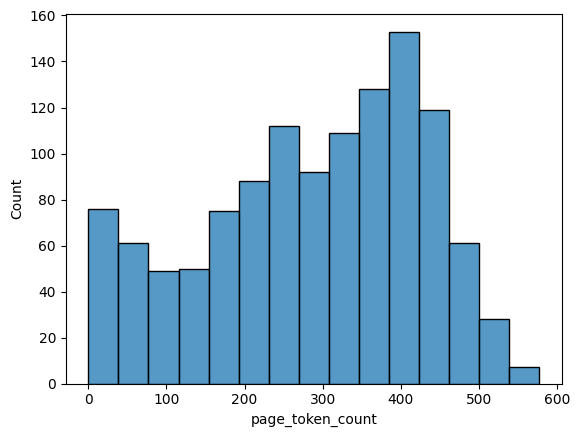

In [11]:
import seaborn as sns

sns.histplot(x='page_token_count', data=df)

Why would we care about token count ?

token count is important to think about:
1. Embedding and LLM models donot deal with infinite tokens


For example the embedding model called [all-mp-base-v2](https://huggingface.co/sentence-transformers/all-mpnet-base-v2) takes 384 tokens as input. So if we put a input with more than this then the model will cut down the text and information would be lost

As fpr LLMs, they can't accept unlimited tokens

All-mp-base-v2 is not the best embedding model out there but it is small in size so it is easy to get started. Here you can explore the leaderboard to check out the best embedding model: [MTEB Leaderboard on hugging face](https://huggingface.co/spaces/mteb/leaderboard)

## Further text processing (splitting pages into sentences)

For Splitting text into sentences we can use:
1. Manually spitting on ". "
2. Or more robust way is to use spaCy or nltk

We will use spacy [sentencizer](https://spacy.io/api/sentencizer)

In [17]:
from spacy.lang.en import English

nlp = English()

## Add a sentencizer pipeline
nlp.add_pipe("sentencizer")

## Create document instance as an example
doc = nlp("This is a sentence. This is another sentence. And this is the last sentence")
assert len(list(doc.sents)) == 3

## Print out the sentences
list(doc.sents)

[This is a sentence., This is another sentence., And this is the last sentence]

In [32]:
for item in tqdm(pages_and_text):
    item['sentences'] = list(nlp(item['text']).sents)

    item['sentences'] = list(map(str, item['sentences']))

    item['page_sentence_count_spacy'] = len(item['sentences'])

  0%|          | 0/1208 [00:00<?, ?it/s]

In [34]:
random.sample(pages_and_text, k=1)

[{'page_number': 376,
  'page_char_count': 795,
  'page_word_count': 141,
  'page_sentence_count': 4,
  'page_token_count': 198.75,
  'text': 'When a  protein is  exposed to a  different  environment , such as  increased  temperature,  it unfolds  into a single  strand of  amino acids.  Figure 6.6 Protein Denaturation  \xa0 Learning Activities  Technology Note: The second edition of the Human  Nutrition Open Educational Resource (OER) textbook  features interactive learning activities.\xa0 These activities are  available in the web-based textbook and not available in the  downloadable versions (EPUB, Digital PDF, Print_PDF, or  Open Document).  Learning activities may be used across various mobile  devices, however, for the best user experience it is strongly  recommended that users complete these activities using a  desktop or laptop computer and in Google Chrome.  \xa0 376  |  The Role of Proteins in Foods: Cooking and Denaturation',
  'sentences': ['When a  protein is  exposed to a 

In [35]:
df = pd.DataFrame(pages_and_text)
df.describe().round(2)

,page_number,page_char_count,page_word_count,page_sentence_count,page_token_count,page_sentence_count_spacy
count,1208.00,1208.00,1208.00,1208.00,1208.00,1208.00
mean,562.50,1148.59,198.89,9.97,287.15,10.32
std,348.86,560.44,95.75,6.19,140.11,6.30
min,-41.00,0.00,1.00,1.00,0.00,0.00
25%,260.75,762.75,134.00,4.00,190.69,5.00
50%,562.50,1232.50,215.00,10.00,308.12,10.00
75%,864.25,1605.25,271.25,14.00,401.31,15.00
max,1166.00,2308.00,429.00,32.00,577.00,28.00


## Chunking our sentences together


The concept of splitting the larger pieces of text into smaller ones is referred to as text splitting or chunking

There is no 100% correct way of doing this. Still on research. For demonstration we will keep it simple, we will split the text into group of 10 sentences.

There are frameworks like LangChain which can help with splitting the text into chunks: [Text-Splitters in LangChain](https://python.langchain.com/docs/modules/data_connection/document_transformers/)


1. Model compatibility: You may want to split a long document into smaller chunks that can fit into your **model's context window**

Say we have a sentence like this and we tokenize it:

<img src='https://miro.medium.com/v2/resize:fit:720/format:webp/0*fS-xiimLEZDBO6JX.png' height=200/>

This long sentence results in 68 tokens. But may be there will be sentence that will be longer than this and results in tokens more than the model token limit


Also we don't want to use more tokens that may result in higher price and computation:

GPT 4 Token limits and corresponding price:

<img src='https://www.slideteam.net/media/catalog/product/cache/1280x720/c/h/chat_gpt_4_api_pricing_details_how_to_use_openai_api_in_business_chatgpt_ss_slide01.jpg' height=200/>





In [42]:
chunk_size=10

## Create a function to split the list of texts recursively into chunk size
## E.g = [20] -> [10,10] or [25] -> [10,10,5]

def split_list(input_list: list, slice_size:int) -> list[list[str]]:
    return [input_list[i:i+slice_size] for i in range(0, len(input_list), slice_size)]

## Test
test_list = list(range(25))
split_list(test_list, chunk_size)

[[0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
 [10, 11, 12, 13, 14, 15, 16, 17, 18, 19],
 [20, 21, 22, 23, 24]]

In [43]:
for item in tqdm(pages_and_text):
    item['sentence_chunks'] = split_list(item['sentences'], chunk_size)
    item['num_chunks'] = len(item['sentence_chunks'])

  0%|          | 0/1208 [00:00<?, ?it/s]

In [44]:
random.sample(pages_and_text, k=1)

[{'page_number': 1136,
  'page_char_count': 1843,
  'page_word_count': 308,
  'page_sentence_count': 19,
  'page_token_count': 460.75,
  'text': 'In the United States, there are additional subgroups that are at  risk and are more likely than others to face hunger and malnutrition.  They include low-income families and the working poor, who are  employed but have incomes below the federal poverty level.  Senior citizens are also a major at-risk group. Many elderly people  are frail and isolated, which affects their ability to meet their dietary  requirements. In addition, many also have low incomes, limited  resources, and difficulty purchasing or preparing food due to health  issues or poor mobility. As a result, more than six million senior  citizens in the United States face the threat of hunger.6  One of the groups that struggles with hunger are the millions  of homeless people across North America. According to a recent  study by the US Conference of Mayors, the majority of reporti

## Splitting each chunk into its own item



In [48]:
 import re

 pages_and_chunks = []

 for item in tqdm(pages_and_text):
    for sentence_chunk in item['sentence_chunks']:
        chunk_dict = {}
        chunk_dict['page_number'] = item['page_number']

        ## Join the sentence Chunk
        joined_sentence_chunk = "".join(sentence_chunk).replace("  ", " ").strip()
        joined_sentence_chunk = re.sub(r"\.([A-Z])", r'. \1', joined_sentence_chunk) ## .A => . A; This will work with any letter

        chunk_dict['sentence_chunk'] = joined_sentence_chunk

        chunk_dict['chunk_char_count'] = len(joined_sentence_chunk)
        chunk_dict['chunk word count'] = len(joined_sentence_chunk.split(" "))
        chunk_dict['chunk_token_count'] = len(joined_sentence_chunk)/4 ## 1 token ~ 4 chars

        pages_and_chunks.append(chunk_dict)

len(pages_and_chunks)

  0%|          | 0/1208 [00:00<?, ?it/s]

1843

In [49]:
random.sample(pages_and_chunks,k=1)

[{'page_number': 442,
  'sentence_chunk': 'Health Consequences of Alcohol Abuse UNIVERSITY OF HAWAI‘I AT MĀNOA FOOD SCIENCE AND HUMAN NUTRITION PROGRAM AND HUMAN NUTRITION PROGRAM Alcoholic drinks in excess contribute to weight gain by substantially increasing caloric intake. However, alcohol displays its two-faced character again in its effects on body weight, making many scientific studies contradictory. Multiple studies show high intakes of hard liquor are linked to weight gain, although this may be the result of the regular consumption of hard liquor with sugary soft drinks, juices, and other mixers. On the other hand drinking beer and, even more so, red wine, is not consistently linked to weight gain and in some studies actually decreases weight gain. The contradictory results of scientific studies that have examined the association of alcohol intake with body weight are partly due to the fact that alcohol contributes calories to the diet. When alcohol is drunk in excess, it reduc

In [50]:
df = pd.DataFrame(pages_and_chunks)
df.describe().round(2)

,page_number,chunk_char_count,chunk word count,chunk_token_count
count,1843.00,1843.00,1843.00,1843.00
mean,583.38,734.83,112.72,183.71
std,347.79,447.43,71.07,111.86
min,-41.00,12.00,3.00,3.00
25%,280.50,315.00,45.00,78.75
50%,586.00,746.00,114.00,186.50
75%,890.00,1118.50,173.00,279.62
max,1166.00,1831.00,297.00,457.75


<Axes: xlabel='chunk_token_count', ylabel='Count'>

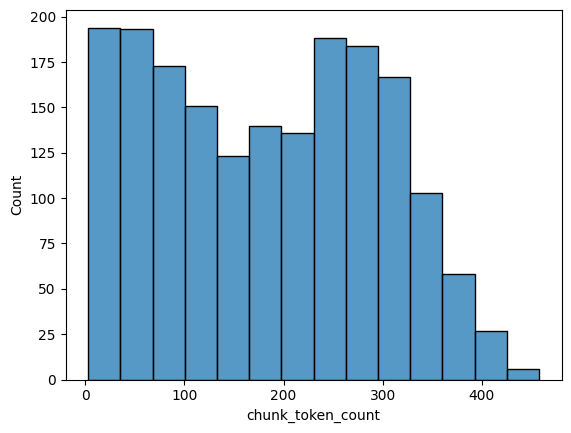

In [52]:
sns.histplot(x='chunk_token_count', data=df)

The embedding model that we are going to use has 384 token limit and from the distribution above we can see most of our chunks are having token size less than that

Also there might be sentences that are having very very less tokens which may not carry useful information for our purpose. Let's say chunks with less than 30 tokens can be considered insignificant and be removed

In [53]:
df[df['chunk_token_count']<30].sample(5)

,page_number,sentence_chunk,chunk_char_count,chunk word count,chunk_token_count
619,385,Figure 6.10 Enzymes Role in Carbohydrate Diges...,88,14,22.00
1273,822,http:/ /www.fao.org/3/ca5162en/ca5162en.pdf 82...,57,5,14.25
1367,880,"Accessed December 10, 2017. 880 | Childhood",43,7,10.75
158,81,http:/ /pressbooks.oer.hawaii.edu/ humannutrit...,84,9,21.00
1057,681,Iodine | 681,12,3,3.00


In [55]:
pages_and_chunks = df[df['chunk_token_count']>30].to_dict(orient='records')
len(pages_and_chunks)

1680

In [56]:
random.sample(pages_and_chunks, k=1)

[{'page_number': 656,
  'sentence_chunk': 'Hemoglobin is composed of four peptides. Each contains a heme group with iron in the center. The iron in hemoglobin binds to oxygen in the capillaries of the lungs and transports it to cells where the oxygen is released. If iron level is low hemoglobin is not synthesized in sufficient amounts and the oxygen-carrying capacity of red blood cells is reduced, resulting in anemia. When iron levels are low in the diet the small intestine more efficiently absorbs iron in an attempt to compensate for the low dietary intake, but this process cannot make up for the excessive loss of iron that occurs with chronic blood loss or low intake. When blood cells are decommissioned for use, the body recycles the iron back to the bone marrow where red blood cells are made. The body stores some iron in the bone marrow, liver, spleen, and skeletal muscle. A relatively small amount of iron is excreted when cells lining the small intestine and skin cells die and in b

## Embedding our text chunks